### initail signal

### Q5.27


In [18]:
import numpy as np
# =============== Q5.27 定点数转换函数 ===============
def float_to_q527(x):
    """将浮点数转换为Q5.27格式 (32位有符号整数)"""
    # Q5.27: 5位整数 + 27位小数
    # 范围: [-16, 16) 理论上，但为了安全使用 [-15.999, 15.999]
    x_clipped = np.clip(x, -16.0, 16.0 - 2**(-27))
    return np.int32(np.round(x_clipped * (2**27)))

def q527_to_float(q):
    """将Q5.27格式转换回浮点数"""
    return q.astype(np.float64) / (2**27)

def q527_multiply(a, b):
    """Q5.27格式的乘法
    结果需要右移27位来保持格式
    """
    # 转换为64位避免溢出
    result = (a.astype(np.int64) * b.astype(np.int64)) >> 27
    return np.int32(result)

def q527_add(a, b):
    """Q5.27格式的加法（带溢出保护）"""
    result = a.astype(np.int64) + b.astype(np.int64)
    # 饱和处理
    result = np.clip(result, np.int32(-2**31), np.int32(2**31 - 1))
    return np.int32(result)

def q527_subtract(a, b):
    """Q5.27格式的减法（带溢出保护）"""
    result = a.astype(np.int64) - b.astype(np.int64)
    result = np.clip(result, np.int32(-2**31), np.int32(2**31 - 1))
    return np.int32(result)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def generate_noise_correlation_signals_float(point_num, rho,amplitude=0.4, safety_margin=0.999):

    noise1_base = np.random.normal(0, 1, point_num)
    noise2_correlated_base = rho * noise1_base + np.sqrt(1 - rho**2) * np.random.normal(0, 1, point_num)

    #使用各自的标准差进行归一化，而不是最大值, 这确保了处理后的噪声仍然是“白”的，且功率可控
    noise1_normalized = noise1_base / np.std(noise1_base)
    noise2_normalized = noise2_correlated_base / np.std(noise2_correlated_base)
    
    noise1_scaled = noise1_normalized * amplitude
    noise2_scaled = noise2_normalized * amplitude

    # 4施加一个安全边界 (Safety Margin)
    max_abs_val = np.max([np.max(np.abs(noise1_scaled)), np.max(np.abs(noise2_scaled))])
    if max_abs_val >= 1.0:
        scaling_factor = safety_margin / max_abs_val
        noise1_final = noise1_scaled * scaling_factor
        noise2_final = noise2_scaled * scaling_factor
    else:
        noise1_final = noise1_scaled
        noise2_final = noise2_scaled

    return noise1_final, noise2_final



def Single_tone_Sine_Wave_float(f0, fs, point_num, target_amplitude):

    t = np.arange(point_num) / fs
    signal_float = np.sin(2 * np.pi * f0 * t)
    signal_scaled = signal_float * target_amplitude
    return signal_scaled

def check_correlation(noise1, noise2):
    noise1 = np.asarray(noise1)
    noise2 = np.asarray(noise2)

    if noise1.shape != noise2.shape:
        print("错误: 两个输入数组的长度必须相同。")
        return None
    
    try:
        corr_matrix = np.corrcoef(noise1, noise2)
        r = corr_matrix[0, 1]
    except Exception as e:
        print(f"计算相关系数时出错: {e}")
        return None

    plt.figure(figsize=(8, 6))
    plt.scatter(noise1, noise2, alpha=0.6, label='Data Points', color='skyblue')

    m, c = np.polyfit(noise1, noise2, 1)
    plt.plot(noise1, m * noise1 + c, color='red', label=f'Best Fit Line (r={r:.4f})')

    plt.title(f'Correlation Scatter Plot (r = {r:.4f})', fontsize=16)
    plt.xlabel('Noise 1 (X-axis)', fontsize=12)
    plt.ylabel('Noise 2 (Y-axis)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    return r

def calculate_snr(signal, noise):
    """计算信噪比 (SNR)，输入为浮点数"""
    power_signal = np.mean(signal**2)
    power_noise = np.mean(noise**2)
    if power_noise == 0 or power_signal == 0: 
        return float('inf') if power_noise == 0 else -float('inf')
    return 10 * np.log10(power_signal / power_noise)

### vss-nlms


In [20]:
# =============== Q5.27 格式的 VSS-NLMS 滤波器 ===============
def vss_nlms_Filter_q527(input_float, desirable_float, order, mu_max=0.5, mu_min=0.01, alpha=0.97, gamma=1e-3, epsilon=1e-6):
    """
    使用Q5.27定点数格式实现的VSS-NLMS滤波器
    输入输出为浮点数，内部使用定点运算
    """
    # 转换输入信号为Q5.27
    input_q527 = float_to_q527(input_float)
    desirable_q527 = float_to_q527(desirable_float)
    
    signal_len = input_float.size
    weight_q527 = np.zeros(order, dtype=np.int32)
    output_signal_q527 = np.zeros(signal_len, dtype=np.int32)
    error_signal_q527 = np.zeros(signal_len, dtype=np.int32)
    delay_line_q527 = np.zeros(order, dtype=np.int32)
    
    # 步长参数保持浮点数（或也可以转为定点，但这里简化处理）
    mu = mu_max * 0.5
    mu_q527 = float_to_q527(mu)
    alpha_q527 = float_to_q527(alpha)
    gamma_q527 = float_to_q527(gamma)
    epsilon_q527 = float_to_q527(epsilon)
    mu_min_q527 = float_to_q527(mu_min)
    mu_max_q527 = float_to_q527(mu_max)
    
    for n in range(signal_len):
        # 更新延迟线
        delay_line_q527 = np.roll(delay_line_q527, 1)
        delay_line_q527[0] = input_q527[n]
        
        # 计算滤波器输出 y = w^T * x
        y_q527 = np.int32(0)
        for i in range(order):
            y_q527 = q527_add(y_q527, q527_multiply(weight_q527[i], delay_line_q527[i]))
        
        # 计算误差 e = d - y
        e_q527 = q527_subtract(desirable_q527[n], y_q527)
        
        # 计算功率 power = x^T * x
        power_q527 = np.int32(0)
        for i in range(order):
            power_q527 = q527_add(power_q527, q527_multiply(delay_line_q527[i], delay_line_q527[i]))
        power_q527 = q527_add(power_q527, epsilon_q527)
        
        # 更新权重 w = w + mu * e * x / power
        # 简化: delta_w = (mu * e / power) * x
        mu_e_q527 = q527_multiply(mu_q527, e_q527)
        
        # 除法近似：使用定点数除法（这里简化为转回浮点处理）
        mu_e_float = q527_to_float(mu_e_q527)
        power_float = q527_to_float(power_q527)
        step_size_float = mu_e_float / power_float
        step_size_q527 = float_to_q527(step_size_float)
        
        for i in range(order):
            delta_w = q527_multiply(step_size_q527, delay_line_q527[i])
            weight_q527[i] = q527_add(weight_q527[i], delta_w)
        
        # 更新步长 mu = mu * alpha + gamma * e^2
        e_squared_q527 = q527_multiply(e_q527, e_q527)
        mu_q527 = q527_add(q527_multiply(mu_q527, alpha_q527), q527_multiply(gamma_q527, e_squared_q527))
        
        # 限制步长范围
        mu_float = q527_to_float(mu_q527)
        mu_float = np.clip(mu_float, mu_min, mu_max)
        mu_q527 = float_to_q527(mu_float)
        
        error_signal_q527[n] = e_q527
        output_signal_q527[n] = y_q527
    
    # 转换回浮点数
    error_signal_float = q527_to_float(error_signal_q527)
    output_signal_float = q527_to_float(output_signal_q527)
    weight_float = q527_to_float(weight_q527)
    
    return error_signal_float, weight_float, output_signal_float
        


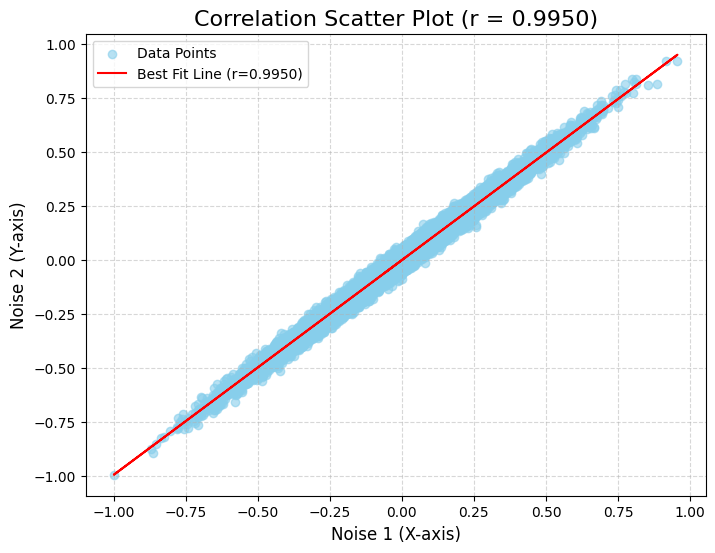


--- Performance Evaluation ---
SNR Before: 4.97 dB
SNR After:  15.77 dB
SNR Improvement: 10.80 dB
Theoretical Max Improvement: 20.01 dB


In [21]:
if __name__ == "__main__":
    point_num = 20000 
    rho = 0.995         
    order = 32          
    fs = 10e6
    f0 = 1e6
    SIGNAL_AMPLITUDE = 0.6 
    NOISE_TARGET_STD = 0.4 

    noise1, noise2 = generate_noise_correlation_signals_float(point_num, rho)
    check_correlation(noise1,noise2)

    clean_signal = Single_tone_Sine_Wave_float(f0, fs, point_num, SIGNAL_AMPLITUDE)
    primary_signal = clean_signal + noise1
    reference_signal = noise2
    snr_before = calculate_snr(clean_signal, noise1)
    after_lms_signal,A,B= vss_nlms_Filter_q527(reference_signal, primary_signal, order)
    residual_noise = after_lms_signal - clean_signal
    snr_after = calculate_snr(clean_signal, residual_noise)
    snr_improvement = snr_after - snr_before
    if rho**2 < 1:
        theoretical_improvement = -10 * np.log10(1 - rho**2)
    else:
        theoretical_improvement = float('inf')

  
    print("\n--- Performance Evaluation ---")
    print(f"SNR Before: {snr_before:.2f} dB")
    print(f"SNR After:  {snr_after:.2f} dB")
    print(f"SNR Improvement: {snr_improvement:.2f} dB")
    print(f"Theoretical Max Improvement: {theoretical_improvement:.2f} dB")
    print("===============================")